# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [10]:
import os
import re
import warnings

from IPython.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
from statistics import geometric_mean

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Read in config file with some parameters, etc.

In [11]:
with open('./neut_data/config.yaml') as f:
    config = yaml.safe_load(f)

Specify input / output files:

In [12]:
# output directory
results='results/neut_titers'
os.makedirs(results, exist_ok = True)

# input files
fracinfect_file = 'neut_data/2022_01_21_fractinfect.csv'

# output files
neut_titers_file = f'{results}/neut_titers.csv'
all_replicate_curves = f'{results}/all_replicate_curves.pdf'

Read in the neutralization data:

In [13]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = (pd.read_csv(fracinfect_file))

# order the viruses
virus_order = config['virus_order']
Ab_order = config['Ab_order']

fracinfect = (
    fracinfect
    .query('virus in @virus_order & serum in @Ab_order')
    .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
)

# show first few lines of data frame
display(HTML(fracinfect.head().to_html(index=False)))

Reading neutralization data from neut_data/2022_01_21_fractinfect.csv


Unnamed: 0,serum,virus,replicate,concentration,fraction infectivity
0,S2H14,Y449H+N501Y,1,400.000,0.6113
1,S2H14,Y449H+N501Y,1,100.000,0.8816
2,S2H14,Y449H+N501Y,1,25.000,0.9173
3,S2H14,Y449H+N501Y,1,6.250,0.9710
4,S2H14,Y449H+N501Y,1,1.562,0.9930


In [14]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate',
            fixbottom=config['fixbottom'],
            fixtop=config['fixtop'],
    
            )

Saving plot to results/neut_titers/all_replicate_curves.pdf



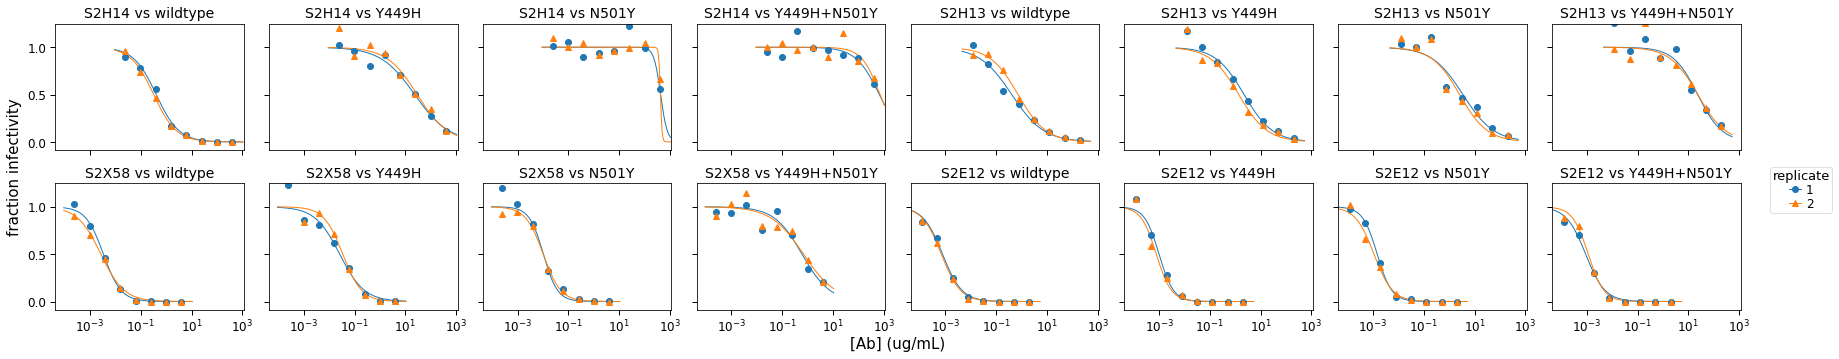

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='[Ab] (ug/mL)',
                                 viruses=fracinfect['virus'].sort_values().unique(),
                                 colors=plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2,
                                 markers=['o', '^', 's', 'D', 'v', '<', '>', 'p'] * 2,
                                 fix_lims={'ymax':1.25},
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [20]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound'])


fits = neutcurve.CurveFits(fracinfect,
                           replicate_col='replicate',
                           fixbottom=config['fixbottom'],
                           fixtop=config['fixtop'],
                          )

fp = (
    fits.fitParams(average_only=False)
    .assign(NT50=lambda x: 1/x['ic50'],
            date=d
           )
    # get columns of interest
    [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'replicate', 'top']] 
    .assign(ic50_is_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                      'interpolated': False}))
    )
fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power


,serum,virus,ic50,NT50,ic50_bound,replicate,top,ic50_is_bound
0,S2H14,Y449H+N501Y,400.0,0.0025,lower,1,True,True
1,S2H14,Y449H+N501Y,400.0,0.0025,lower,2,True,True
2,S2H14,Y449H+N501Y,400.0,0.0025,lower,average,True,True
3,S2H14,N501Y,400.0,0.0025,lower,1,True,True
4,S2H14,N501Y,400.0,0.0025,lower,2,True,True


### Compare IC50s and fold-change IC50s when the top of the neutralization curve is fixed vs. not fixed

Here we compare the IC50s and fold-change IC50s with the two different methods of fitting the curves. 
See the config file for how we ultimately decided to fit curves.

In [22]:
fitparams_fixtop = pd.DataFrame(columns=['serum', 'virus', 'ic50_fixtop'])

if config['fixtop']:
    fixtop_alternative=False
else:
    fixtop_alternative=True

fits = neutcurve.CurveFits(fracinfect,
                           replicate_col='replicate',
                           fixtop=fixtop_alternative,
                          )

fp = (
    fits.fitParams(average_only=False)
    # get columns of interest
    [['serum', 'virus', 'ic50', 'replicate']]
    .rename(columns={'ic50':'ic50_fixtop'})
    )
fitparams_fixtop=fitparams_fixtop.append(fp, ignore_index=True)

fitparams_fixtop = (fitparams_fixtop
                    .merge(fitparams_fixtop
                           .query('virus == "wildtype"')
                           [['serum', 'ic50_fixtop', 'replicate']]
                           .rename(columns={'ic50_fixtop': 'wildtype_ic50_fixtop'}),
                           on=['serum', 'replicate'],
                           how='left',
                           validate='many_to_one',
                          )
                    .assign(fold_change=lambda x: x['ic50_fixtop'] / x['wildtype_ic50_fixtop'],
                           )
                    .merge(fitparams
                           [['virus', 'serum', 'ic50', 'replicate']]
                           .merge(fitparams.query('virus == "wildtype"')
                                  [['serum', 'ic50', 'replicate']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
                                  on=['serum', 'replicate'],
                                  how='left',
                                  validate='many_to_one',
                                 )
                           .assign(fold_change_fixtop=lambda x: x['ic50'] / x['wildtype_ic50'],
                                  ),
                           how='outer',
                           on=['serum', 'virus', 'replicate']
                          )
                   )


display(HTML(fitparams_fixtop.head().to_html()))

,serum,virus,ic50_fixtop,replicate,wildtype_ic50_fixtop,fold_change,ic50,wildtype_ic50,fold_change_fixtop
0,S2H14,Y449H+N501Y,400.0,1,0.455750,877.674688,400.0,0.407483,981.636877
1,S2H14,Y449H+N501Y,400.0,2,0.307527,1300.700411,400.0,0.323736,1235.572787
2,S2H14,Y449H+N501Y,400.0,average,0.374758,1067.355126,400.0,0.363163,1101.433193
3,S2H14,N501Y,400.0,1,0.455750,877.674688,400.0,0.407483,981.636877
4,S2H14,N501Y,400.0,2,0.307527,1300.700411,400.0,0.323736,1235.572787


Plot correlations between IC50 whether top is fixed or not

/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/fixtop_corr_ic50.pdf


/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/fixtop_corr_fold_change.pdf


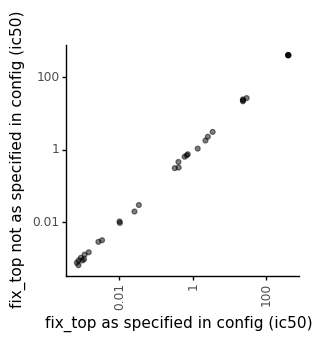

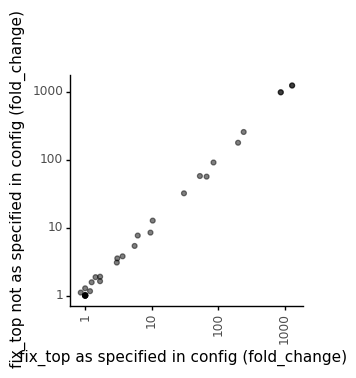

In [23]:
for param in [('ic50', 'ic50_fixtop'), ('fold_change', 'fold_change_fixtop')]:
    p = (ggplot(fitparams_fixtop
                .query("replicate != 'average'")
                ) +
         aes(param[0], param[1],
            ) +
         geom_point(size=1.5, alpha=0.5, ) + #fill='#999999', 
         scale_x_log10(name=f'fix_top as specified in config ({param[0]})') +
         scale_y_log10(name=f'fix_top not as specified in config ({param[0]})') +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(3, 3),
               ) +
         scale_fill_manual(values=CBPALETTE*3)
         )

    _ = p.draw()
    
    plotfile = f'{results}/fixtop_corr_{param[0]}.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

Make a plot showing all viruses against each sera:

/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
/fh/fast/bloom_j/computational_notebooks

Saving to results/neut_titers/mutant_neuts.pdf


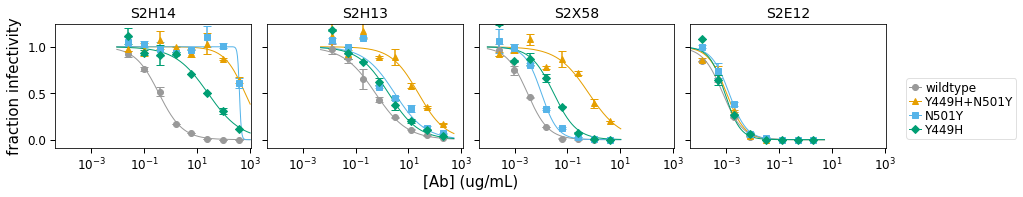

In [26]:
fits = (neutcurve.CurveFits(fracinfect, 
                            replicate_col='replicate', 
                            fixbottom=config['fixbottom'],
                            fixtop=config['fixtop'],
                           )
       )
xlab= '[Ab] (ug/mL)'
name= 'antibody'

fig, axes = fits.plotSera(xlabel=xlab,max_viruses_per_subplot=4,
                          colors=CBPALETTE*3, 
                          markers=CBMARKERS*3,
#                          attempt_shared_legend=True,
                          fix_lims={'ymax':1.25}
                         )

plotfile = f'{results}/mutant_neuts.pdf'
print(f"Saving to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

### Calculate fold-change IC50 relative to the gemetric mean of the wildtype virus against each Ab
* Get neutralization titers, 
* Drop "average" replicate
* Calculate the geometric mean of the wildtype virus against each Ab
* Calculate fold-change IC50

In [27]:
neut_titers = (
    fitparams
    .merge((fitparams
            .query('virus == "wildtype" & replicate != "average"')
            .groupby(['serum'])
            
            # get the geometric mean of the two wildtype replicates 
            .agg(wildtype_ic50=pd.NamedAgg(column="ic50", aggfunc=geometric_mean))
            .reset_index()
           ),
           on=['serum'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],)
    )


display(HTML(neut_titers.head().to_html(index=False)))
neut_titers.to_csv(neut_titers_file, index=False)

serum,virus,ic50,NT50,ic50_bound,replicate,top,ic50_is_bound,wildtype_ic50,fold_change
S2H14,Y449H+N501Y,400.0,0.0025,lower,1,True,True,0.363204,1101.310044
S2H14,Y449H+N501Y,400.0,0.0025,lower,2,True,True,0.363204,1101.310044
S2H14,Y449H+N501Y,400.0,0.0025,lower,average,True,True,0.363204,1101.310044
S2H14,N501Y,400.0,0.0025,lower,1,True,True,0.363204,1101.310044
S2H14,N501Y,400.0,0.0025,lower,2,True,True,0.363204,1101.310044


As we can see below, the fold-change in IC50 for each wildtype replicate is no longer exactly 1 (because we are comparing to the geometric mean of the replicate measurements). Here I am pulling out hte most extreme fold_change IC50s for wildtype (relative to the geometric mean), and we see that the most extreme values are 0.75 and 1.32, for M03-day-119 on 2021-07-16. 

In [28]:
display(HTML(neut_titers.query('virus=="wildtype" & replicate != "average" & (fold_change <0.8 | fold_change >1.25)').head(100).to_html(index=False)))

serum,virus,ic50,NT50,ic50_bound,replicate,top,ic50_is_bound,wildtype_ic50,fold_change
S2H13,wildtype,0.413570,2.417969,interpolated,1,True,False,0.550463,0.751314
S2H13,wildtype,0.732667,1.364877,interpolated,2,True,False,0.550463,1.331002


### Plot the fold-change IC50 relative to wildtype.

/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/fold_change_IC50_average.pdf


/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


Saving to results/neut_titers/fold_change_IC50_not_average.pdf


/fh/fast/bloom_j/computational_notebooks/tstarr/2021/SARS-CoV-2-RBD_DMS_variants/env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


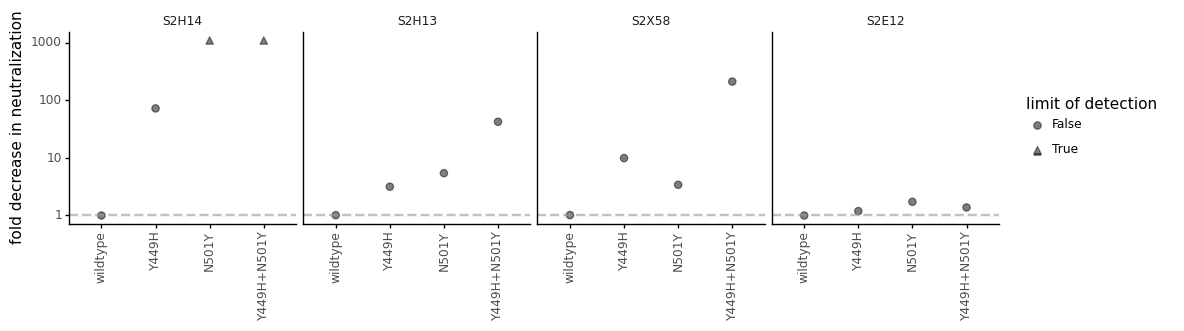

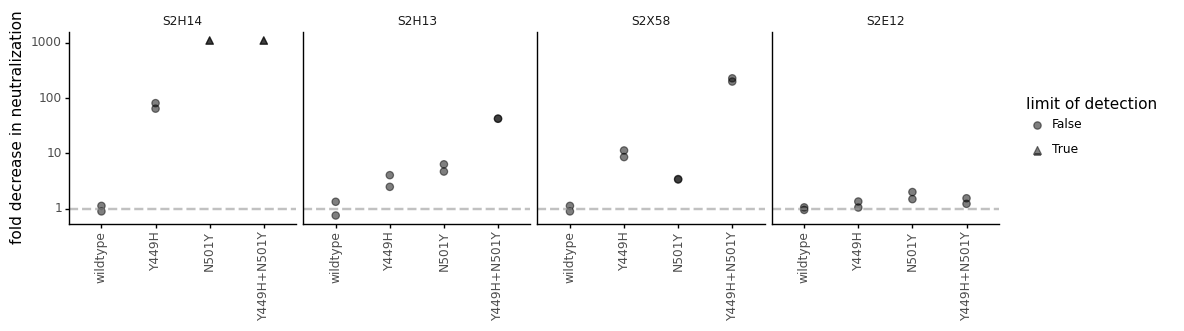

In [44]:
neut_titers = (neut_titers
               .assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=Ab_order),
                       virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=virus_order),
                      )
               )

for b in ('average', 'not_average'):
    if b=='average':
        df = neut_titers.query('replicate=="average"')
    else:
        df = neut_titers.query('replicate!="average"')
    p = (ggplot(df
                ) +
         aes('virus', 'fold_change', shape='ic50_is_bound',
            ) +
         geom_point(size=2.5, alpha=0.5) + 
         scale_y_log10(name='fold decrease in neutralization') +
         facet_wrap('~serum', ncol=4, scales='free_x') +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               axis_title_x=element_blank(),
               strip_background_x=element_blank(),
               subplots_adjust={'hspace': 1.15},
               figure_size=(12, 2.5),
               ) +
         geom_hline(yintercept=1, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         scale_shape_manual(values=['o','^'], name='limit of detection')+
         scale_fill_manual(values=CBPALETTE[1:]*3)
         )

    _ = p.draw()

    plotfile = f'{results}/fold_change_IC50_{b}.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)